In [1]:
## LSTM for stock ##

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Input, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from keras import regularizers
from keras import initializers
from keras import constraints
from keras import activations
from keras import losses
from keras import metrics
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import models
from keras import utils
from keras import backend as K

2023-08-23 16:43:49.911489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import mplfinance as mpf

In [10]:
df = pd.read_csv('data.csv')
df.head()

,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,2007-02-04,13.0,13.0,12.0,12.0,640374172370,172898994,2489,13.0,12.0
1,2007-02-05,12.0,12.0,12.0,12.0,40902501888,10826496,1709,12.0,12.0
2,2007-02-06,13.0,13.0,13.0,13.0,103453562449,26850133,4118,12.0,13.0
3,2007-02-07,13.0,13.0,13.0,13.0,122171316570,31086849,4247,13.0,13.0
4,2007-02-10,13.0,13.0,13.0,13.0,162907276224,40645528,4984,13.0,13.0


In [11]:
# change data to be campatible to mplfinance #
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index(df['date'])
df = df.drop(['date'], axis=1)
df.head()


,open,high,low,adjClose,value,volume,count,yesterday,close
date,,,,,,,,,
2007-02-04,13.0,13.0,12.0,12.0,640374172370,172898994,2489,13.0,12.0
2007-02-05,12.0,12.0,12.0,12.0,40902501888,10826496,1709,12.0,12.0
2007-02-06,13.0,13.0,13.0,13.0,103453562449,26850133,4118,12.0,13.0
2007-02-07,13.0,13.0,13.0,13.0,122171316570,31086849,4247,13.0,13.0
2007-02-10,13.0,13.0,13.0,13.0,162907276224,40645528,4984,13.0,13.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


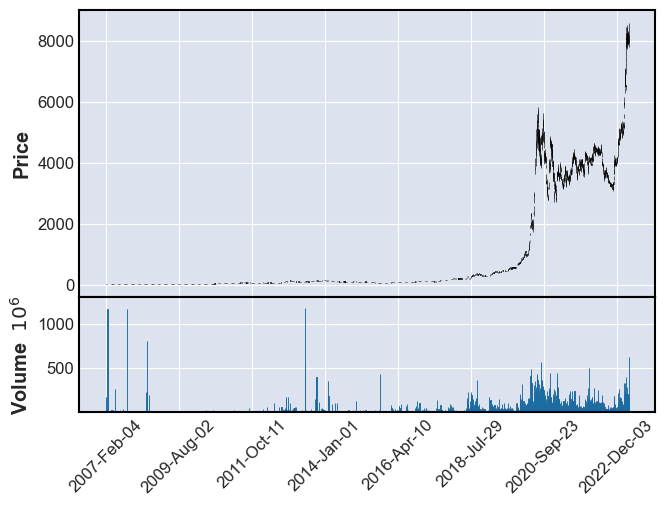

In [5]:
# plot stock price in candlestick chart with mplfinance #
mpf.plot(df, type='candle', volume=True)

In [8]:
df.shape

(3586, 9)

In [12]:
## add ichimoku cload data ##
# add ichimoku cloud data
def ichimoku(df):
    nine_period_high = df['high'].rolling(window= 9).max()
    nine_period_low = df['low'].rolling(window= 9).min()
    df['tenkan_sen'] = (nine_period_high + nine_period_low) /2

    period26_high = df['high'].rolling(window=26).max()
    period26_low = df['low'].rolling(window=26).min()
    df['kijun_sen'] = (period26_high + period26_low) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)

    period52_high = df['high'].rolling(window=52).max()
    period52_low = df['low'].rolling(window=52).min()
    df['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)

    df['chikou_span'] = df['close'].shift(-26)

    return df

train = ichimoku(df)

In [13]:
# moving average indicator #
def moving_average(df):
    df['ma5'] = df['close'].rolling(window=5).mean()
    df['ma10'] = df['close'].rolling(window=10).mean()
    df['ma20'] = df['close'].rolling(window=20).mean()
    df['ma60'] = df['close'].rolling(window=60).mean()
    df['ma120'] = df['close'].rolling(window=120).mean()
    df['ma240'] = df['close'].rolling(window=240).mean()
    return df

train = moving_average(df)


In [14]:
# add RSI data #
def RSI(df):
    U = np.where(df['close'].diff(1) > 0, df['close'].diff(1), 0)
    D = np.where(df['close'].diff(1) < 0, df['close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U).rolling(window=14, min_periods=14).mean()
    AD = pd.DataFrame(D).rolling(window=14, min_periods=14).mean()
    RSI = AU.div(AD+AU)*100
    df['RSI'] = RSI.values
    return df

train = RSI(df)

In [ ]:
# clear train data from NaN and ... #
train = train.dropna()


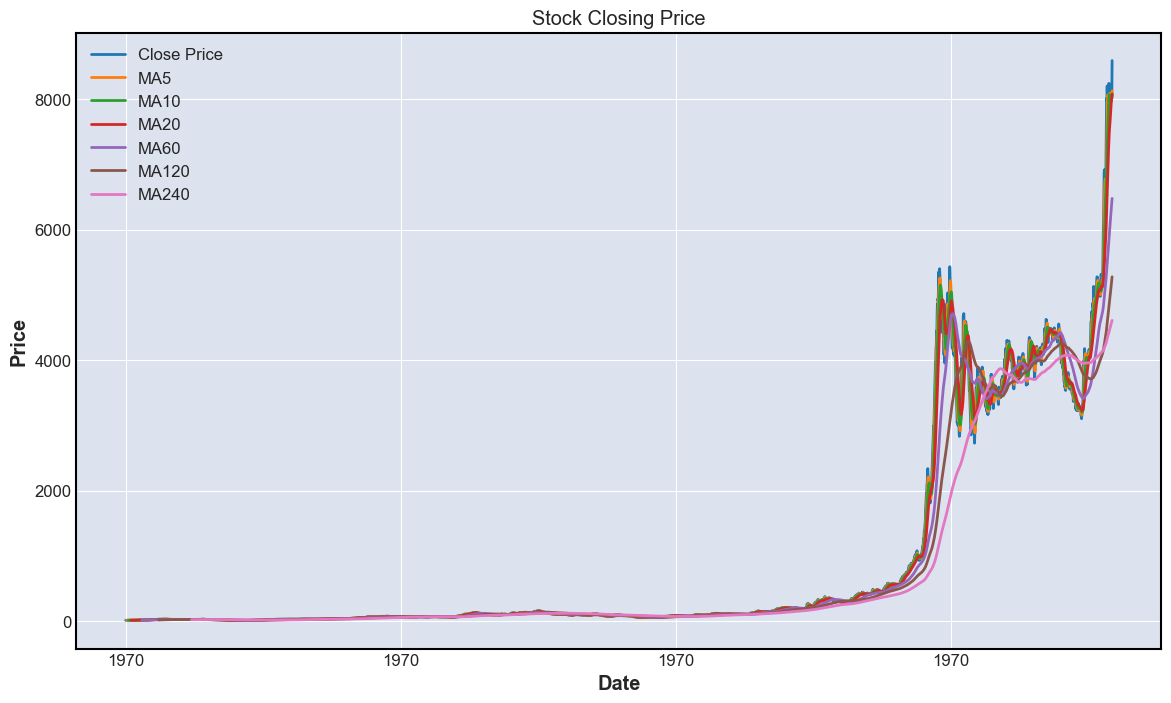

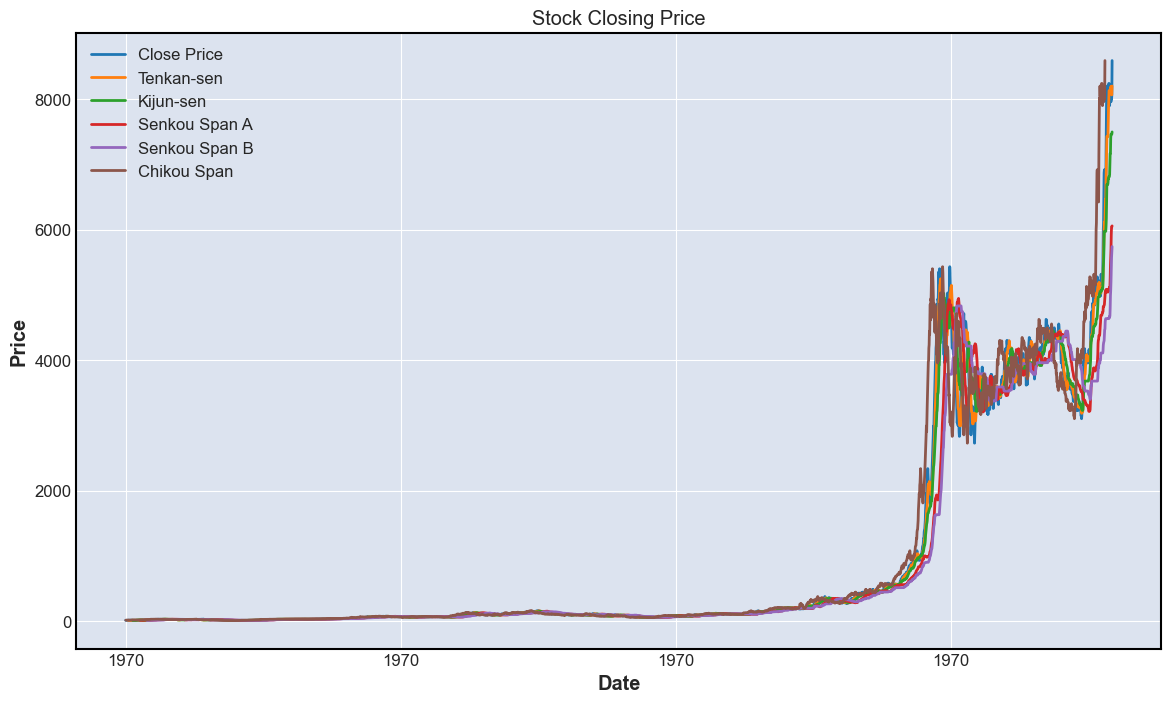

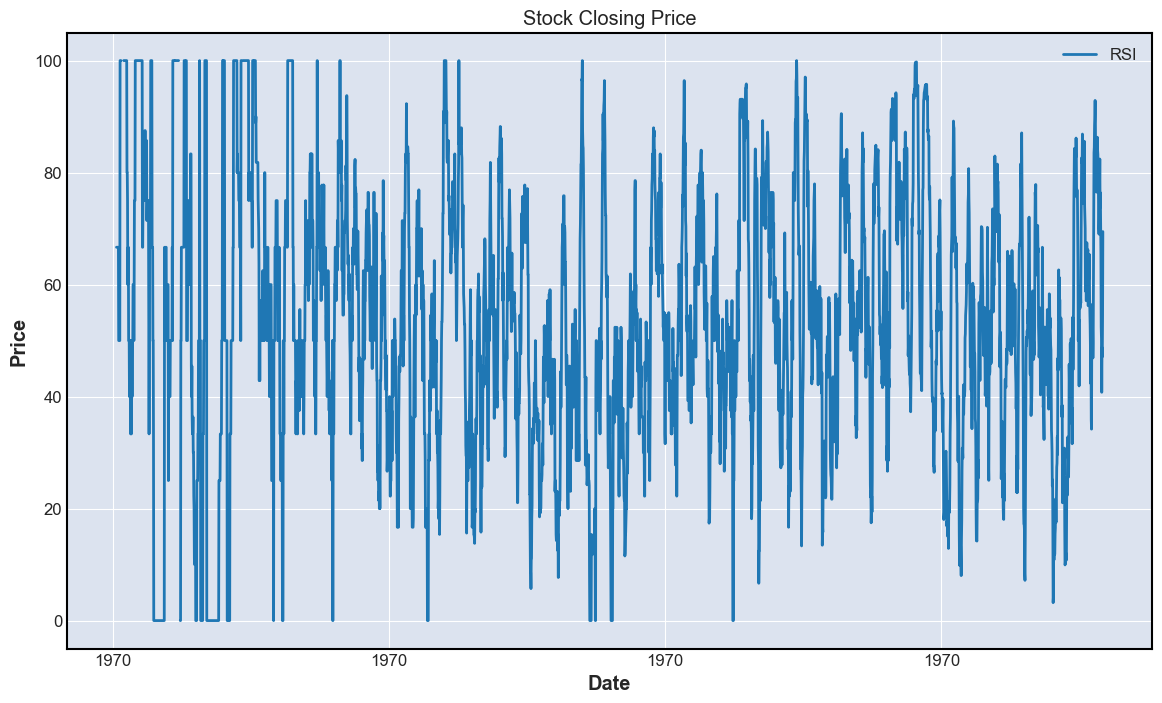

In [15]:
# plot stock in candle with indicator #
def plot_stock(df):
    df = df.reset_index()
    df.index = pd.to_datetime(df.index)
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Stock Closing Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.plot(df['close'], label='Close Price')
    ax.plot(df['ma5'], label='MA5')
    ax.plot(df['ma10'], label='MA10')
    ax.plot(df['ma20'], label='MA20')
    ax.plot(df['ma60'], label='MA60')
    ax.plot(df['ma120'], label='MA120')
    ax.plot(df['ma240'], label='MA240')
    ax.legend()
    plt.show()

plot_stock(df)

# plot ichimoku cloud #
def plot_ichimoku(df):
    df = df.reset_index()
    df.index = pd.to_datetime(df.index)
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Stock Closing Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.plot(df['close'], label='Close Price')
    ax.plot(df['tenkan_sen'], label='Tenkan-sen')
    ax.plot(df['kijun_sen'], label='Kijun-sen')
    ax.plot(df['senkou_span_a'], label='Senkou Span A')
    ax.plot(df['senkou_span_b'], label='Senkou Span B')
    ax.plot(df['chikou_span'], label='Chikou Span')
    ax.legend()
    plt.show()

plot_ichimoku(df)

# plot RSI #
def plot_RSI(df):
    df = df.reset_index()
    df.index = pd.to_datetime(df.index)
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Stock Closing Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.plot(df['RSI'], label='RSI')
    ax.legend()
    plt.show()

plot_RSI(df)

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

In [ ]:
# seprate data frame data to stock data and indicator data #
stock_columbs = ['open', 'high', 'low', 'close', 'volume']
# using key #
stock_data = pd.DataFrame(train, columns=stock_columbs)
stock_data.head()

In [ ]:
# seperate indicators data #
indicator_columbs = ['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span', 'ma5', 'ma10', 'ma20', 'ma60', 'ma120', 'ma240', 'RSI']
indicator_data = pd.DataFrame(train, columns=indicator_columbs)

In [21]:
# seperate stock, average, ichimoku cloud, RSI from normalized data #
stock_data = train[:, 0:5]
average_data = train[:, 5:11]
ichimoku_data = train[:, 11:17]
RSI_data = train[:, 17:18]



In [22]:
# create data set with 4 sequential 1 month input (stock, average, ichimoku cloud, RSI) and 2 output (mean of close and open data)
def create_dataset(stock_data, average_data, ichimoku_data, RSI_data, look_back=20):
    dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI, dataY = [], [], [], [], []
    for i in range(len(stock_data)-look_back-1):
        a = stock_data[i:(i+look_back), :]
        b = average_data[i:(i+look_back), :]
        c = ichimoku_data[i:(i+look_back), :]
        d = RSI_data[i:(i+look_back), :]
        dataX_stock.append(a)
        dataX_average.append(b)
        dataX_ichimoku.append(c)
        dataX_RSI.append(d)
        # y ---> mean of open and close in a week a (2, n) array
        dataY.append([np.mean(stock_data[i + look_back: i+look_back+5, 0]), np.mean(stock_data[i + look_back: i+look_back+5, 3])])
    return np.array(dataX_stock), np.array(dataX_average), np.array(dataX_ichimoku), np.array(dataX_RSI), np.array(dataY)


In [23]:
dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI, dataY = create_dataset(stock_data, average_data, ichimoku_data, RSI_data, look_back=20)

In [24]:
# print shape of inputs #
print(dataX_stock.shape)
print(dataX_average.shape)
print(dataX_ichimoku.shape)
print(dataX_RSI.shape)

(3565, 20, 5)
(3565, 20, 6)
(3565, 20, 6)
(3565, 20, 1)


In [ ]:
# normalize eatch data #
scaler_stock = MinMaxScaler(feature_range=(0, 1))
scaler_average = MinMaxScaler(feature_range=(0, 1))
scaler_ichimoku = MinMaxScaler(feature_range=(0, 1))
scaler_RSI = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

dataX_stock = scaler_stock.fit_transform(dataX_stock.reshape(-1, 5)).reshape(-1, 20, 5)
dataX_average = scaler_average.fit_transform(dataX_average.reshape(-1, 6)).reshape(-1, 20, 6)
dataX_ichimoku = scaler_ichimoku.fit_transform(dataX_ichimoku.reshape(-1, 6)).reshape(-1, 20, 6)
dataX_RSI = scaler_RSI.fit_transform(dataX_RSI.reshape(-1, 1)).reshape(-1, 20, 1)
dataY = scaler_y.fit_transform(dataY)


In [25]:
# tensorflow lstm with 4 sequential input #
# net work with two different input
def lstm_model(x_stock, x_average, x_ichimoku, x_RSI, y):
    input_1 = Input(shape=(x_stock.shape[1], x_stock.shape[2]))
    input_2 = Input(shape=(x_average.shape[1], x_average.shape[2]))
    input_3 = Input(shape=(x_ichimoku.shape[1], x_ichimoku.shape[2]))
    input_4 = Input(shape=(x_RSI.shape[1], 1))

    # layer with one axis #
    lstm_1 = LSTM(16, return_sequences=True)(input_1)
    
    lstm_2 = LSTM(16, return_sequences=True)(input_2)
    
    lstm_3 = LSTM(16, return_sequences=True)(input_3)

    lstm_4 = LSTM(4, return_sequences=True)(input_4)

    # flatten layer
    # lstm_1 = layers.Flatten()(lstm_1)
    lstm_2 = layers.Flatten()(lstm_2)
    lstm_3 = layers.Flatten()(lstm_3)
    lstm_4 = layers.Flatten()(lstm_4)
    

    lstm_5 = concatenate([lstm_2, lstm_3, lstm_4], axis=1)
    # output to one dimension
    lstm_5 = layers.Flatten()(lstm_5)

    # add dence with size and axis
    lstm_5 = Dense(64, activation='relu')(lstm_5)

    lstm_6 = Dense(64, activation='relu')(lstm_1)
    lstm_6 = layers.Flatten()(lstm_6)


    
    # concat stock and idicator data
    lstm_7 = concatenate([lstm_6, lstm_5], axis=1) # stock + indicator
    # output to one dimension
    lstm_7 = layers.Flatten()(lstm_7)

    lstm_7 = Dense(64, activation='relu')(lstm_7)

    lstm_7 = Dense(y.shape[0], activation='linear')(lstm_7)


    # return model
    return Model(inputs=[input_1, input_2, input_3, input_4], outputs=lstm_7)

In [26]:
# make model #
model = lstm_model(dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI, dataY)
model.summary()

2023-08-23 16:47:18.735625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-23 16:47:18.738702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-23 16:47:18.740483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 6)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 20, 6)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 20, 16)       1472        ['input_2[0][0]']                
                                                                                              

2023-08-23 16:47:20.004437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-23 16:47:20.006563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-23 16:47:20.008780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                                                  
 lstm_3 (LSTM)                  (None, 20, 4)        96          ['input_4[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 20, 5)]      0           []                               
                                                                                                  
 flatten (Flatten)              (None, 320)          0           ['lstm_1[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 320)          0           ['lstm_2[0][0]']                 
                                                                                                  
 flatten_2 (Flatten)            (None, 80)           0           ['lstm_3[0][0]']                 
          

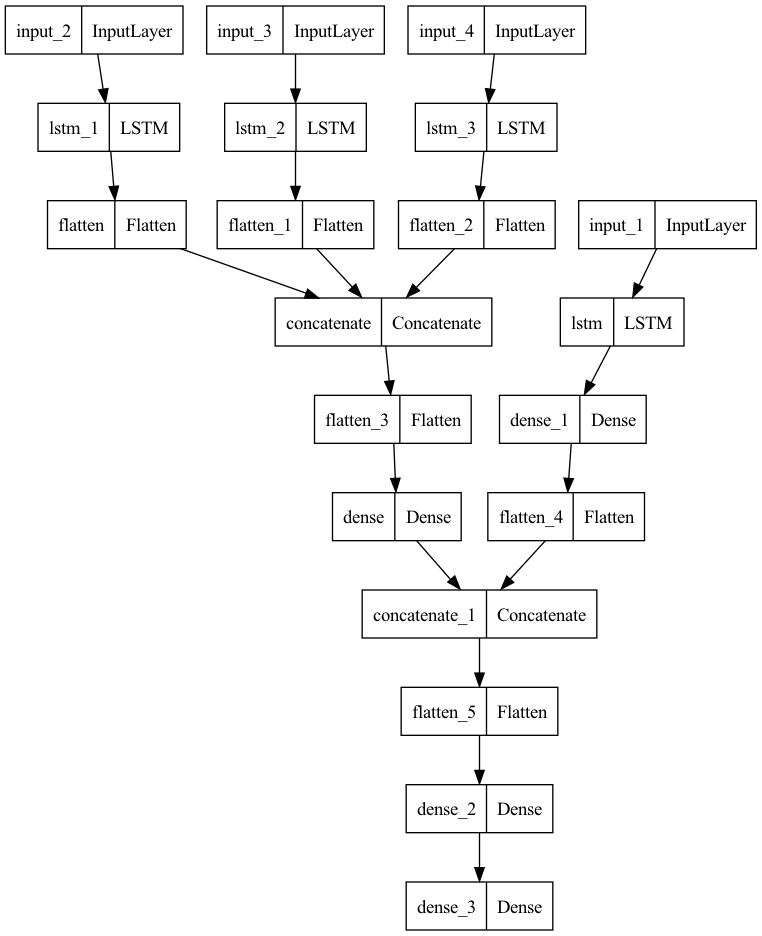

In [27]:
# plot model #
plot_model(model, to_file='model.png')

In [ ]:
# change datat to tensor #
dataX_stock = tf.convert_to_tensor(dataX_stock, dtype=tf.float32)
dataX_average = tf.convert_to_tensor(dataX_average, dtype=tf.float32)
dataX_ichimoku = tf.convert_to_tensor(dataX_ichimoku, dtype=tf.float32)
dataX_RSI = tf.convert_to_tensor(dataX_RSI, dtype=tf.float32)
dataY = tf.convert_to_tensor(dataY, dtype=tf.float32)

# compile model #
model.compile(loss='mean_squared_error', optimizer='adam')

# set callback #
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# save model
model_path = 'model.h5'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

# set tensorboard #
log_dir = 'log'
tensorboard = TensorBoard(log_dir=log_dir)


In [ ]:
# train model #
history = model.fit([dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI], dataY, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping, checkpoint, tensorboard])

In [ ]:
# plot loss #
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# predict data #
trainPredict = model.predict([dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI])

In [ ]:
# denormalize out put with defferent shape #
trainPredict = trainPredict.reshape(-1, 1)
trainPredict = scaler.inverse_transform(trainPredict)

In [ ]:
# last 20 day data for predict #
last_20_day = train[-20:, :]
stock_last_20_day = last_20_day[:, 0:5]
average_last_20_day = last_20_day[:, 5:11]
ichimoku_last_20_day = last_20_day[:, 11:17]
RSI_last_20_day = last_20_day[:, 17:18]
# reshape data to be compatible to model #
stock_last_20_day = stock_last_20_day.reshape(1, 20, 5)
average_last_20_day = average_last_20_day.reshape(1, 20, 6)
ichimoku_last_20_day = ichimoku_last_20_day.reshape(1, 20, 6)
RSI_last_20_day = RSI_last_20_day.reshape(1, 20, 1)

Predict_data = model.predict([stock_last_20_day, average_last_20_day, ichimoku_last_20_day, RSI_last_20_day])

# plot predict data #
plt.plot(last_20_day[:, 0], label='last 20 day')
plt.plot(trainPredict[:, 0], label='predict')
plt.legend()
plt.show()

In [ ]:
# save model in all details #
model.save('model.h5')

# load model #
model = load_model('model.h5')